In [ ]:
import numpy as np
import matplotlib.pyplot as plt

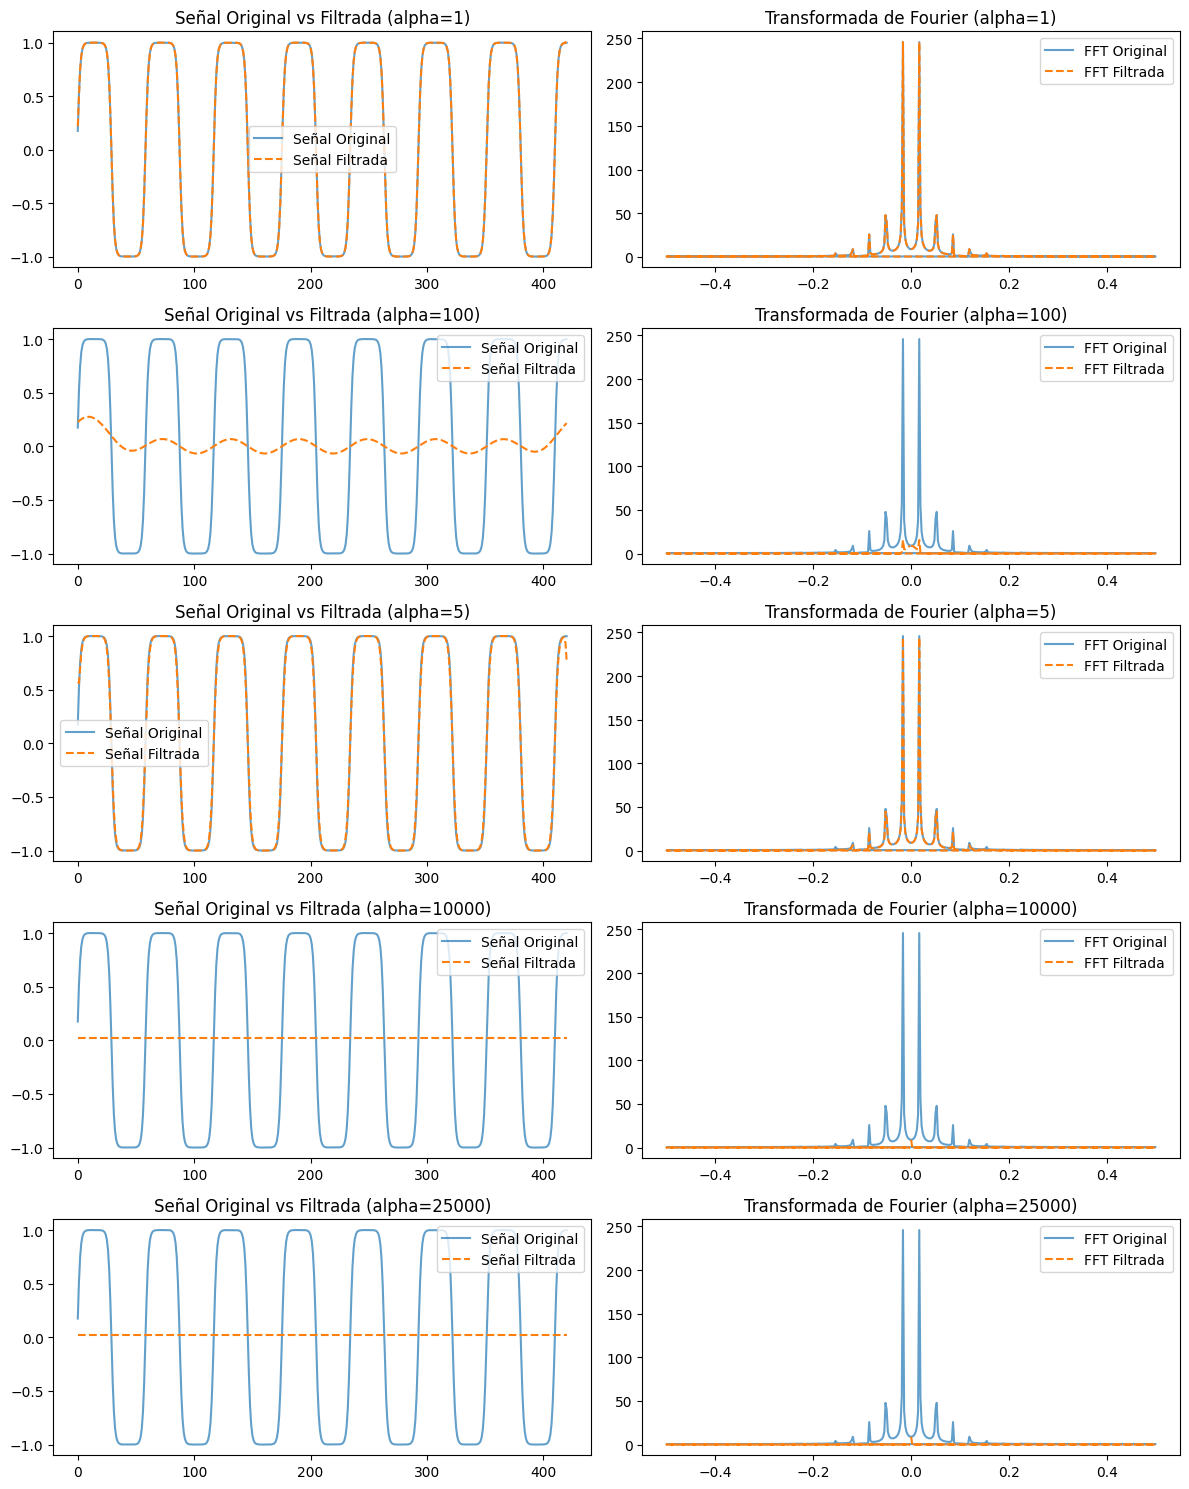

In [8]:
#Cargar datos
manchas_sol = np.loadtxt("H_field.csv", skiprows=1, delimiter=",")
manchas_sol = manchas_sol[:,1]
fft_signal = np.fft.fft(manchas_sol) #transformada de furier rapida
freq = np.fft.fftfreq(len(fft_signal)) #Fracuencias para cada punto
#Defino varios alfas para el filtro gauseano
alphas = [1, 100, 5, 10000, 25000]

fig, axs = plt.subplots(len(alphas), 2, figsize=(12, 3 * len(alphas)))

for i, alpha in enumerate(alphas):
    # El filtro
    filtro = np.exp(- (freq * alpha) ** 2)

    # Aplico el filtro
    fft_filtrada = fft_signal * filtro
    senal_filtrada = np.fft.ifft(fft_filtrada)

    # Graficar 
    axs[i, 0].plot(manchas_sol, label='Señal Original', alpha=0.7)
    axs[i, 0].plot(senal_filtrada.real, label='Señal Filtrada', linestyle='--')
    axs[i, 0].set_title(f'Señal Original vs Filtrada (alpha={alpha})')
    axs[i, 0].legend()

    axs[i, 1].plot(freq, np.abs(fft_signal), label='FFT Original', alpha=0.7)
    axs[i, 1].plot(freq, np.abs(fft_filtrada), label='FFT Filtrada', linestyle='--')
    axs[i, 1].set_title(f'Transformada de Fourier (alpha={alpha})')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


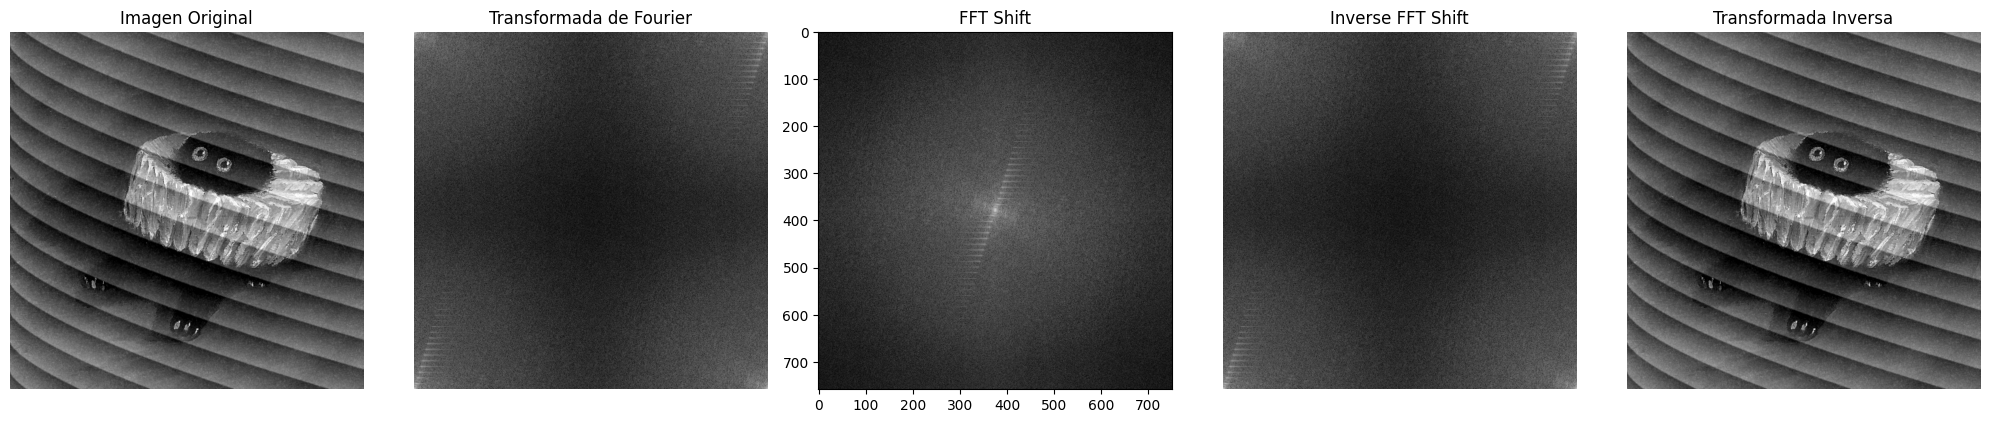

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar imágenes
catto = plt.imread("catto.png")
casttle = plt.imread("Noisy_Smithsonian_Castle.jpg")

def subsampling(X, s):
    (N, M) = X.shape
    N2 = int(N / s)
    M2 = int(M / s)
    
    Y = np.zeros((N2, M2))
    for i2 in range(N2):
        i = int(i2 * s)
        for j2 in range(M2):
            j = int(j2 * s)
            Y[i2, j2] = X[i, j]
    
    return Y
# Transformadas de Fourier
f_catto = np.fft.fft2(catto)                 # Transformada de Fourier
fshift_catto = np.fft.fftshift(f_catto)      # Desplazamiento del cero de frecuencia al centro
ishift_catto = np.fft.ifftshift(fshift_catto)  # Inversión del desplazamiento
inverse_catto = np.fft.ifft2(ishift_catto)   # Transformada Inversa de Fourier
inverse_catto = np.abs(inverse_catto)        # Magnitud real para visualizar

# Crear figura con 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# 1. Imagen original
axs[0].imshow(catto, cmap='gray')
axs[0].set_title('Imagen Original')
axs[0].axis('off')

# 2. Transformada de Fourier (espectro de magnitud)
axs[1].imshow(np.log(np.abs(f_catto) + 1), cmap='gray')
axs[1].set_title('Transformada de Fourier')
axs[1].axis('off')

# 3. FFT Shift (centrado del espectro)
axs[2].imshow(np.log(np.abs(fshift_catto) + 1), cmap='gray')
axs[2].set_title('FFT Shift')
axs[2].axis('on')

# 4. Inversión del Shift
axs[3].imshow(np.log(np.abs(ishift_catto) + 1), cmap='gray')
axs[3].set_title('Inverse FFT Shift')
axs[3].axis('off')

# 5. Transformada Inversa de Fourier
axs[4].imshow(inverse_catto, cmap='gray')
axs[4].set_title('Transformada Inversa')
axs[4].axis('off')

plt.tight_layout()
plt.show()


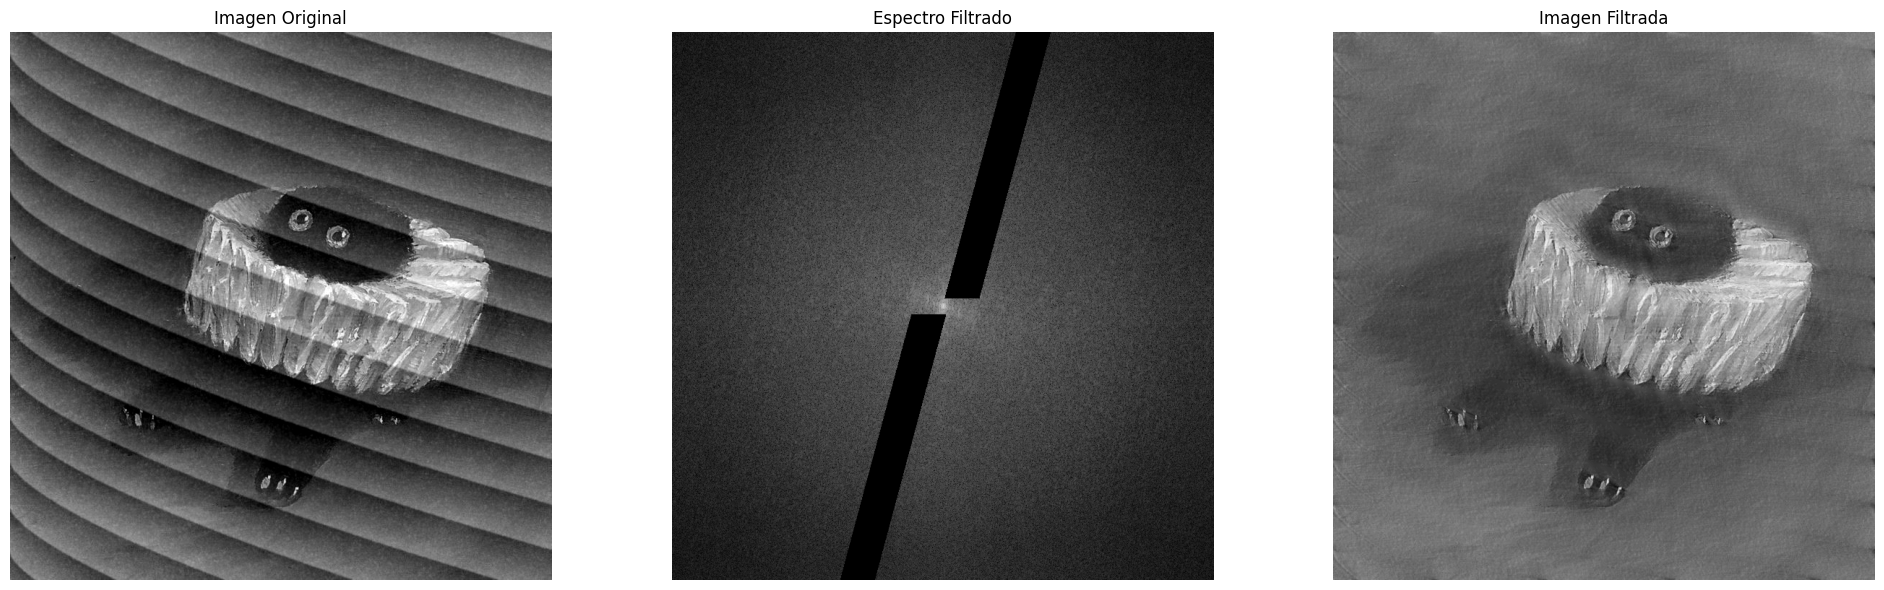

In [12]:

#cargar imegen como array
catto = plt.imread("catto.png")

# Se reliso la ransfiormada de furier y luego se cwentraron la frecuencias para asi identificiar patrones que sean repetitibos par asi
# eliminar este ruido. Para esta imagen ajustamos dos iagonales una abajo y otra arriba y tambien empleamos una elimpce para protejer datos de frecuencias
# fundamentales que no se deben borrar. Sereemplaza el valor de la as frecuencias encerrada por cero dado que son la que se quieren elimina.

def diagonal_filter_catto(shape, angle=-45, width=10, value=0, desplazamiento_sup=-120, desplazamiento_inf=-80, a=11, b=900):
    rows, cols = shape[:2]
    filtro = np.ones((rows, cols))

    # Diagonal superior
    for i in range(rows // 2):
        for j in range(cols):
            x = i - rows / 2
            y = j - cols / 2
            if abs(i - (j - rows / 2 + desplazamiento_sup) * np.tan(np.radians(angle))) < width and (x/a)**2 + (y/b)**2 > 1:
                filtro[i, j] = value  

    #diagonal inferior
    for i in range(rows // 2, rows):
        for j in range(cols):
            x = i - rows / 2
            y = j - cols / 2
            if abs(i - (j - rows / 2 + desplazamiento_inf) * np.tan(np.radians(angle))) < width and (x/a)**2 + (y/b)**2 > 1:
                filtro[i, j] = value 

    return filtro


#aplica el filtro
def aplicar_notch_filter_catto(img, D0, notch_centers, angle, width,diagonal=False):
    f_transformada = np.fft.fft2(img)
    fshift = np.fft.fftshift(f_transformada)
    filtro = diagonal_filter_catto(img.shape, angle, width, value=0) 
    fshift_filtrado = fshift * filtro
    f_ishift = np.fft.ifftshift(fshift_filtrado)
    img_filtrada = np.fft.ifft2(f_ishift).real

    return img_filtrada, fshift_filtrado, filtro

#Parametros de las coordenadas de las diagonales
notch_centers = [(256, 300), (256, 212)]  

D0 = 15   #anchura de las diagonales


img_filtrada, espectro_filtrado, diagonal_mask = aplicar_notch_filter_catto(catto, D0, notch_centers, diagonal=True, angle=-75, width=90)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(catto, cmap='gray')
axs[0].set_title('Imagen Original')
axs[0].axis('off')

axs[1].imshow(np.log(1 + np.abs(espectro_filtrado)), cmap='gray')
axs[1].set_title('Espectro Filtrado')
axs[1].axis('off')

axs[2].imshow(img_filtrada, cmap='gray')
axs[2].set_title('Imagen Filtrada')
axs[2].axis('off')

plt.tight_layout()
plt.show()


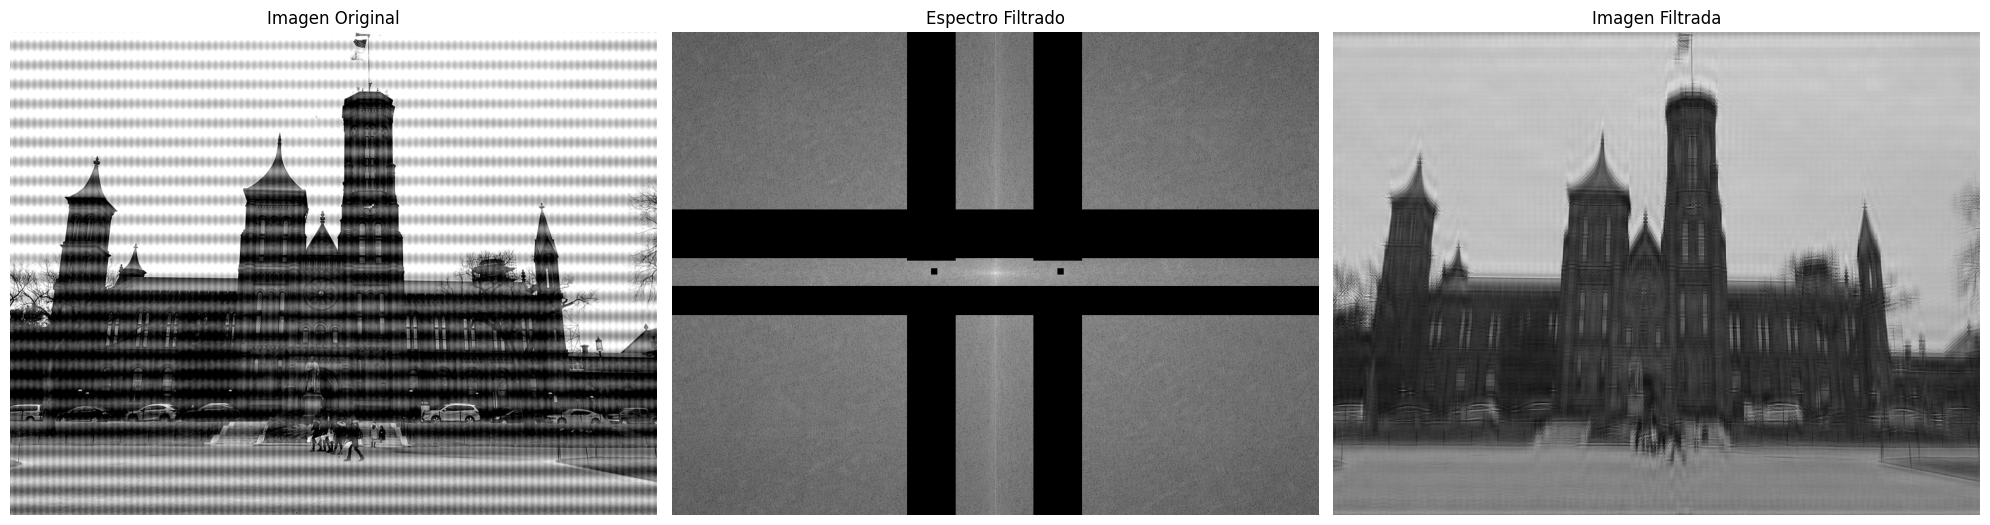

In [14]:


casttle = plt.imread("Noisy_Smithsonian_Castle.jpg")

def notch_filter_casttle(shape, pos_izq, pos_der, pos_sup, pos_inf, width, value=0, a=20, b=9000):
    rows, cols = shape[:2]
    filtro = np.ones((rows, cols))

    for i in range(rows):
        for j in range(cols):
            x = i - rows / 2
            y = j - cols / 2

            fuera_elipse = (x/a)**2 + (y/b)**2 > 1

            en_linea_izq = abs(j - pos_izq) < width // 2
            en_linea_der = abs(j - pos_der) < width // 2
            en_linea_sup = abs(i - pos_sup) < width // 2
            en_linea_inf = abs(i - pos_inf) < width // 2

            if (en_linea_izq or en_linea_der or en_linea_sup or en_linea_inf) and fuera_elipse:
                filtro[i, j] = value

    return filtro

def eliminar_cuadrados(filtro, centros, tamanio):
    for (x_centro, y_centro) in centros:
        x_min = max(0, x_centro - tamanio // 2)
        x_max = min(filtro.shape[0], x_centro + tamanio // 2)
        y_min = max(0, y_centro - tamanio // 2)
        y_max = min(filtro.shape[1], y_centro + tamanio // 2)

        filtro[x_min:x_max, y_min:y_max] = 0

    return filtro

def aplicar_notch_filter_casttle(img, pos_izq, pos_der, pos_sup, pos_inf, width, cuadrados):
    f_transformada = np.fft.fft2(img)
    fshift = np.fft.fftshift(f_transformada)
    filtro = notch_filter_casttle(img.shape, pos_izq=pos_izq, pos_der=pos_der, pos_sup=pos_sup, pos_inf=pos_inf, width=width)
    filtro = eliminar_cuadrados(filtro, cuadrados, tamanio=10)
    fshift_filtrado = fshift * filtro
    f_ishift = np.fft.ifftshift(fshift_filtrado)
    img_filtrada = np.fft.ifft2(f_ishift).real

    return img_filtrada, fshift_filtrado, filtro

pos_izq = 410
pos_der = 610
pos_sup = 320
pos_inf = 410
width = 78
cuadrados = [(380, 415), (380, 615)]  


img_filtrada, espectro_filtrado, filtro_mask = aplicar_notch_filter_casttle(casttle, pos_izq, pos_der, pos_sup, pos_inf, width, cuadrados)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(casttle, cmap='gray')
axs[0].set_title('Imagen Original')
axs[0].axis('off')

axs[1].imshow(np.log(1 + np.abs(espectro_filtrado)), cmap='gray')
axs[1].set_title('Espectro Filtrado')
axs[1].axis('off')

axs[2].imshow(img_filtrada, cmap='gray')
axs[2].set_title('Imagen Filtrada')
axs[2].axis('off')

plt.tight_layout()
plt.show()
